# Preprocessing Using spaCy
### Overview
After previously cleaning the review text using AWS Glue, this notebook will complete the preprocessing by using spaCy to tokenize the text so that the data can be used for model training and analysis.

## Import libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import re
import spacy
from spacy import displacy
import awswrangler as wr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Verify installed version of spaCy.

In [3]:
spacy.__version__

'3.5.0'

## 1. Import data from S3
Data will be imported from S3 which has been previously cleaned in AWS Glue. Prior cleaning involved removing whitespace, lowercasing the text, and removing early access reviews since these reviews provided very little information.

In [4]:
df = wr.s3.read_csv(path='s3://siads696-wi23-steam-data/write_down_dyf_to_s3/')

In [5]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,107410,Arma 3,this is not a game for people who want fast ac...,1,1
1,107410,Arma 3,oh man. where to even begin with this one. it ...,1,1
2,107410,Arma 3,my first game on a3 brought me the most horrif...,1,0
3,107410,Arma 3,i spent several years in the army and i gotta ...,1,1
4,107410,Arma 3,having accumulated over 13400 hours in-game wi...,1,1


In [6]:
df.shape

(846712, 5)

In [7]:
df.dtypes

app_id           int64
app_name        object
review_text     object
review_score     int64
review_votes     int64
dtype: object

## 2. Preprocessing and Data Exploration
### Check for missing values
As part of the preprocessing done in AWS Glue we dropped records with missing text but as a sanity check we will check once more if there are any records that have a missing review.

In [8]:
df.isnull().sum()

app_id           0
app_name         0
review_text     16
review_score     0
review_votes     0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

### 2.2 Clean text using ReGex
Here we create a function that removes puncuation and only keep words.

In [11]:
def cleaner(df):
    """
        Applies regex to review_text column to clean text
        
        Input:
            dataframe
        
        Returns:
            dataframe with clean_text column
    """

    pattern = re.compile(r"\b\w*[']\w*\b|[a-zA-Z]+")
    
    df['clean_text'] = df['review_text'].str.findall(pattern).str.join(' ')
    
    return df

Produce a new dataframe after removing punctuation and retaining only words for each review.

In [12]:
%%time
df_clean = cleaner(df)

CPU times: user 18.2 s, sys: 318 ms, total: 18.5 s
Wall time: 18.4 s


### 2.3 Drop rows with empty text after applying regex
After using the regex to clean the text, we will now identify if there are any rows with empty text and drop them.

In [13]:
print('Rows to drop:', len(df_clean[df_clean['clean_text'] == '']))

Rows to drop: 10422


In [14]:
df_clean = df_clean[df_clean['clean_text'] != '']

In [15]:
df_clean.shape

(836274, 6)

### 2.4 Check for duplicate reviews and drop
Let's see if any reviews are duplicates and spot check the reviews.

In [16]:
len(df_clean[df_clean.duplicated(subset=['app_name', 'clean_text'])].sort_values(['app_name','clean_text']))

183821

In [17]:
df_clean[(df_clean['app_name'] == 'Warframe') &  (df_clean['clean_text'].str.startswith('you wanna know how good i think'))]

,app_id,app_name,review_text,review_score,review_votes,clean_text
817414,230410,Warframe,you wanna know how good i think this game is? ...,1,0,you wanna know how good i think this game is i...
817425,230410,Warframe,you wanna know how good i think this game is? ...,1,0,you wanna know how good i think this game is i...
817426,230410,Warframe,you wanna know how good i think this game is? ...,1,0,you wanna know how good i think this game is i...


We can see that for the game Warframe there are 3 reviews that start with the text 'you wanna know how good i think'. Let's see if they are identical to each other.

In [18]:
print(df_clean.loc[817414]['clean_text'])
print(df_clean.loc[817425]['clean_text'])
print(df_clean.loc[817426]['clean_text'])

you wanna know how good i think this game is it's free to play and i spend money on it v
you wanna know how good i think this game is it's free to play and i spend money on it v
you wanna know how good i think this game is it's free to play and i spend money on it v


In [19]:
# check for string match
df_clean.loc[817414]['clean_text'] == df_clean.loc[817425]['clean_text'] == df_clean.loc[817426]['clean_text']

True

The 3 reviews are an exact match and we are going to drop all duplicated reviews except for the first occurrence.

In [20]:
df_clean = df_clean.drop_duplicates(subset=['app_name', 'clean_text'], keep='first')

In [21]:
df_clean.shape

(652453, 6)

### 2.4 Data exploration
### Plot histogram of number of words per review
The dataset currently sits at 651K reviews.  Before moving forward, let's get the length of words in each review and the distribution.

In [22]:
df_clean['num_words'] = df_clean['clean_text'].apply(lambda x: len(str(x).split()))

In [23]:
df_clean.head()

,app_id,app_name,review_text,review_score,review_votes,clean_text,num_words
0,107410,Arma 3,this is not a game for people who want fast ac...,1,1,this is not a game for people who want fast ac...,457
1,107410,Arma 3,oh man. where to even begin with this one. it ...,1,1,oh man where to even begin with this one it wo...,674
2,107410,Arma 3,my first game on a3 brought me the most horrif...,1,0,my first game on a brought me the most horrifi...,198
3,107410,Arma 3,i spent several years in the army and i gotta ...,1,1,i spent several years in the army and i gotta ...,179
4,107410,Arma 3,having accumulated over 13400 hours in-game wi...,1,1,having accumulated over hours in game with arm...,40


Plot a histram of bins containing 25 words.

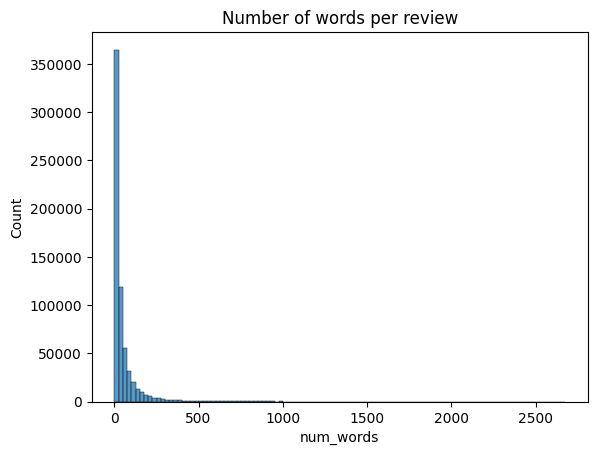

In [24]:
sns.histplot(data = df_clean, x = 'num_words', binwidth = 25)
plt.title('Number of words per review')
plt.show()

### Calculate quantiles for number of words in a review

In [25]:
print(df_clean['num_words'].min())
print(df_clean['num_words'].quantile(0.05))
print(df_clean['num_words'].quantile(0.25))
print(df_clean['num_words'].median())
print(df_clean['num_words'].quantile(0.95))
print(df_clean['num_words'].quantile(0.99))
print(df_clean['num_words'].max())

1
4.0
10.0
21.0
197.0
478.0
2665


In [27]:
my_dict = {'.05':df_clean['num_words'].quantile(0.05),
           '.25': df_clean['num_words'].quantile(0.25),
           '.95': df_clean['num_words'].quantile(0.95),
           '.99': df_clean['num_words'].quantile(0.99)}

df_quantile = pd.DataFrame(my_dict.items(), columns=['Quantile','Count of Words'])


bars= alt.Chart(df_quantile).mark_bar().encode(
    x = alt.X("Quantile", axis = alt.Axis(labelAngle = 0)),
    y = alt.Y("Count of Words", scale = alt.Scale(domain=[0,600]))
)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy = -10    
).encode(
    text='Count of Words:Q'
)

(bars + text).properties(
    width = 600,
    height = 400,
    title = "Number of Words per Quantitle"
).configure_axis(grid=False)


alt.LayerChart(...)

### Plot boxenplot

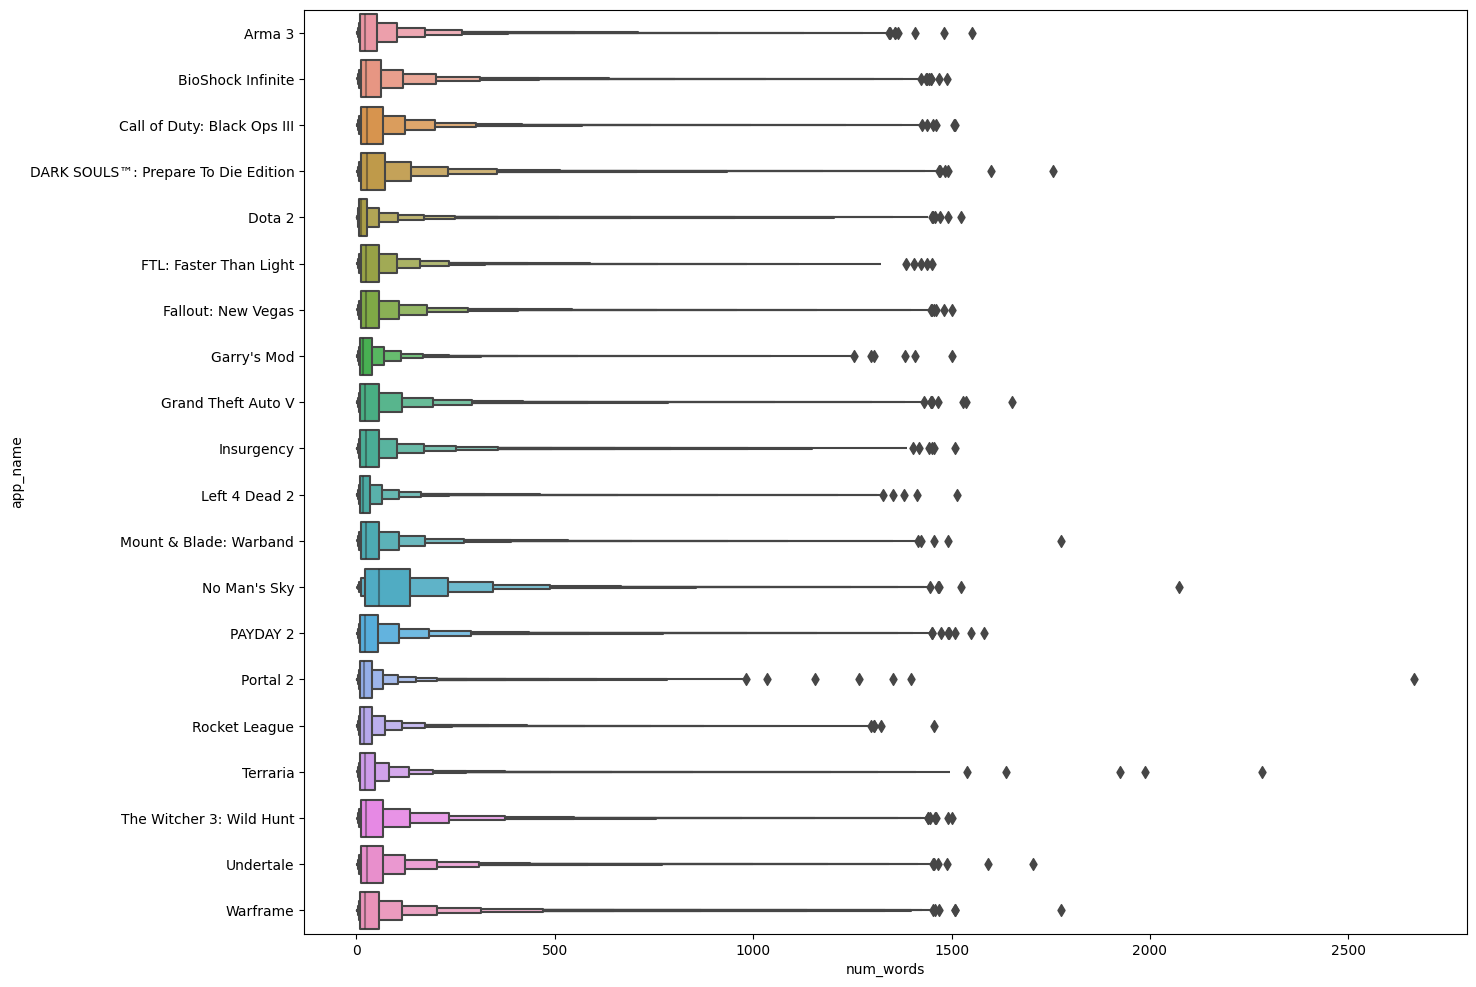

In [28]:
plt.figure(figsize=(15,12))
sns.boxenplot(x = "num_words", y = "app_name", 
              data = df_clean)
plt.show()

### 2.5 Reduce the dataset
Since 5% of the reviews have 4 words or less and 95% of reviews have 197 words or less, we will reduce the dataset to only keep reviews than have more than 4 words and at most 197 words. This will also help to remove some of the noise within our reviews.

In [29]:
df_clean = df_clean[(df_clean['num_words'] >= 5) & (df_clean['num_words'] <= 197)]
df_clean.shape

(575223, 7)

Let's review the distribution of the number of words in each review after reducing the dataset.

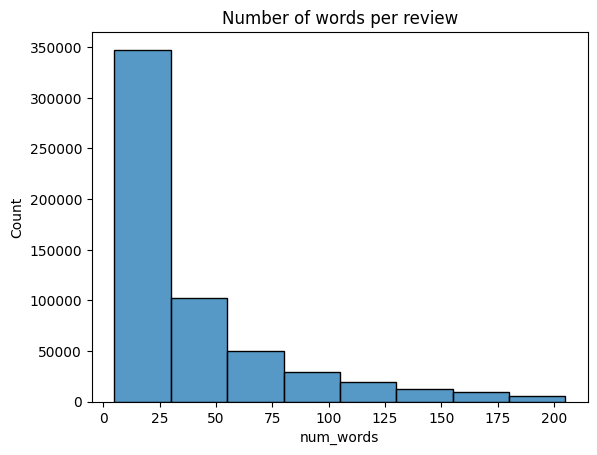

In [30]:
sns.histplot(data = df_clean, x = 'num_words', binwidth = 25)
plt.title('Number of words per review')
plt.show()

## 3. Setup the language processing pipeline
Load the small language library `'en_core_web_sm'` into spaCy.

In [32]:
nlp = spacy.load('en_core_web_sm')

spaCy takes in raw text and returns back a Doc object which is a sequence of token objects:
- Doc - A container for accessing linguistic annotations.
- Token - An individual token, i.e., a word, punctuation symbol, whitespace, etc.

<img src="pipeline.svg" width=600 />

### Visualizing the dependency parse
Depenency parsing is a language processing technique that allows us to better determine the meaning of a sentence by analyzing how it’s constructed to determine how the individual words relate to each other. Here we will visualize the syntactic structure of a sentence using spaCy's syntactic dependency visualizer. Let's start by converting a review into a spaCy document.

In [33]:
df_clean['review_text'].iloc[8]

"it's not a good 'game' for newbies. no, it's not...  i use to sit at a place and watch the sunset. i have no idea how to actually shoot, drive and complete missions.  it's like my personal sunset simulator. and it's damn beautiful.  10/10"

In [34]:
doc = nlp(df_clean['review_text'].iloc[7])
displacy.render(doc, style = 'dep', jupyter = True, options = {'distance':80})

### Visualizing the entity recognizer
Visualize entities in the text of the first review.

In [35]:
doc = nlp(df_clean['review_text'].iloc[100])
displacy.render(doc, style = 'ent', jupyter = True)

## 4. Tokenize the text using processing pipeline
The `nlp.pipe` object will be used to tokenize the clean text, lemmatize each token, and return the token if it's not stopword. 

In [36]:
df_clean.shape

(575223, 7)

In [37]:
df_clean.head()

,app_id,app_name,review_text,review_score,review_votes,clean_text,num_words
3,107410,Arma 3,i spent several years in the army and i gotta ...,1,1,i spent several years in the army and i gotta ...,179
4,107410,Arma 3,having accumulated over 13400 hours in-game wi...,1,1,having accumulated over hours in game with arm...,40
6,107410,Arma 3,joined exile sever. found a 8 year old kid. ki...,1,0,joined exile sever found a year old kid kid sa...,59
7,107410,Arma 3,"after some 1,400 hours on the game, i can say ...",1,1,after some hours on the game i can say with fu...,34
8,107410,Arma 3,this game made me realize that 15fps is playable.,1,0,this game made me realize that fps is playable,9


In [38]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

### 4.1 Use parallelization job to preprocess the reviews
We create a function to lemmatize each token in each doc and remove the token if it's a stopword.  Each doc is a review so we will be creating approximately 575K documents and generating tokens for each document since we have 575K reviews.

When creating the `nlp.pip` object we are going to disable the parser and ner (named entity recognition) because they are computationally expensive and not necessary for our task.

In [39]:
# get a set of stop words from spaCy nlp object
stopwords = nlp.Defaults.stop_words

def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    '''
        Returns a list of lemmatized texts
        
        Parameters:
            texts: a list of strings
        
        Returns:
            texts_out: a list of tokenized strings
    '''
    
    texts_out = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"], batch_size=1000, n_process=4):
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags and token not in stopwords:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

Test the lemmatization function.

In [59]:
lemmatization(df_clean.iloc[:1]['clean_text'])

['spend several year army get say game spot training atmosphere military provide love difficult game love different feature game provide easy hit target assault rifle yard real life game seem match same difficulty fatigue real thing seriously hinder accuracy real life make stop catch breath run too far carry too much gear hard time hit target enemy stupid great vision engage enemy yard away use bush cover as well second rush move ai more advanced average taliban real life haha p give love military videogame one definitely favorite time']

Create a small dataset to test out parallelization job.

In [49]:
# create a copy to avoid SettingWithCopyWarning
df_clean_small = df_clean.iloc[:8000].copy()

In [50]:
df_clean_small.head()

,app_id,app_name,review_text,review_score,review_votes,clean_text,num_words
3,107410,Arma 3,i spent several years in the army and i gotta ...,1,1,i spent several years in the army and i gotta ...,179
4,107410,Arma 3,having accumulated over 13400 hours in-game wi...,1,1,having accumulated over hours in game with arm...,40
6,107410,Arma 3,joined exile sever. found a 8 year old kid. ki...,1,0,joined exile sever found a year old kid kid sa...,59
7,107410,Arma 3,"after some 1,400 hours on the game, i can say ...",1,1,after some hours on the game i can say with fu...,34
8,107410,Arma 3,this game made me realize that 15fps is playable.,1,0,this game made me realize that fps is playable,9


The script below used to create a parallelization job can be attributed to Prashanth Rao who posted a blog on how to speed up nlp pipeline processing using spaCy.  The blog can be found at:  https://prrao87.github.io/blog/spacy/nlp/performance/2020/05/02/spacy-multiprocess.html

In [51]:
from joblib import Parallel, delayed

def lemmatize_pipe(doc, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    lemma_list = [token.lemma_ for token in doc
                  if token.pos_ in allowed_postags and token not in stopwords] 
    return lemma_list

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"], batch_size=20):
        lemma_string = ' '.join(lemmatize_pipe(doc))
        preproc_pipe.append(lemma_string)
    return preproc_pipe

def parallel_lemmatization_pipeline(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(df_clean), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [52]:
%%time
df_clean_small['lemmatization'] = lemmatization(df_clean_small['clean_text'])

CPU times: user 4.37 s, sys: 146 ms, total: 4.52 s
Wall time: 8.04 s


In [57]:
%%time
df_clean_small['preproc_parallel'] = parallel_lemmatization_pipeline(df_clean_small['clean_text'], chunksize=1000)

CPU times: user 305 ms, sys: 202 ms, total: 507 ms
Wall time: 4.61 s


In [58]:
df_clean_small['preproc_parallel'].iloc[0]

'spend several year army get say game spot training atmosphere military provide love difficult game love different feature game provide easy hit target assault rifle yard real life game seem match same difficulty fatigue real thing seriously hinder accuracy real life make stop catch breath run too far carry too much gear hard time hit target enemy stupid great vision engage enemy yard away use bush cover as well second rush move ai more advanced average taliban real life haha p give love military videogame one definitely favorite time'

### 4.2 Apply lemmatization function to clean text
Apply the preprocessing nlp pipeline on the `clean_text` column and generate a new column of lemmatized tokens as a string.

In [60]:
# create a new column called clean_tokens and apply preprocess_pipe function to clean_text
df_clean['clean_tokens'] = parallel_lemmatization_pipeline(df_clean['clean_text'], chunksize=1000)

Review processed token strings.

In [61]:
df_clean.head()

,app_id,app_name,review_text,review_score,review_votes,clean_text,num_words,clean_tokens
3,107410,Arma 3,i spent several years in the army and i gotta ...,1,1,i spent several years in the army and i gotta ...,179,spend several year army get say game spot trai...
4,107410,Arma 3,having accumulated over 13400 hours in-game wi...,1,1,having accumulated over hours in game with arm...,40,have accumulate hour game certainly recommend ...
6,107410,Arma 3,joined exile sever. found a 8 year old kid. ki...,1,0,joined exile sever found a year old kid kid sa...,59,join exile sever find year old kid kid say m l...
7,107410,Arma 3,"after some 1,400 hours on the game, i can say ...",1,1,after some hours on the game i can say with fu...,34,hour game say full validity game ruin life lik...
8,107410,Arma 3,this game made me realize that 15fps is playable.,1,0,this game made me realize that fps is playable,9,game make realize fps playable


## 5. Upload data to S3 bucket

Write to csv and include original review text.

In [62]:
cols = ['app_id','app_name','review_score','review_votes','num_words','clean_tokens','review_text']

wr.s3.to_csv(
    df=df_clean[cols],
    path='s3://siads696-wi23-steam-data/clean_data/reviews_clean_new_full.csv',
    index=False
)

{'paths': ['s3://siads696-wi23-steam-data/clean_data/reviews_clean_new_full.csv'],
 'partitions_values': {}}

Write to csv that will be used for Redshift database.

In [63]:
cols = ['app_id','app_name','review_score','review_votes','num_words','clean_tokens']

wr.s3.to_csv(
    df=df_clean[cols],
    path='s3://siads696-wi23-steam-data/clean_data/reviews_clean_new.csv',
    index=False
)

{'paths': ['s3://siads696-wi23-steam-data/clean_data/reviews_clean_new.csv'],
 'partitions_values': {}}